# Predicting the Number of Health Plan Options in a Given County

In [1]:
# Import libraries 
import pandas as pd
import numpy as np
#from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
#import plotly.express as px
#import plotly.figure_factory as ff
#import geopandas as gpd
#from shapely.geometry import Point, Polygon
#%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso 
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble  import BaggingRegressor

In [2]:
# Set Printing Options
font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12}

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 60)

## The Data

In [4]:
# Set paths and file names

projpath='C:\\Users\\l_gas\\Documents\\Development\\SpringBoard_DataScience\\CapstoneProj1'

# Read analytic file with regional population measures and merge with party affiliation data
plans_data = (pd.read_json("./plans_data.json"))

plans_data.head()


,fips,count_plans,count_issuers,state,st,fips_st,fips_county,CBSA,CBSA_Name,CBSA_Ind,CBSA_Status,Num_Hosp2017,Pop2017,MedIncome2017,IndMarketEnroll2017,Unemployment,State Code,Pparty,Market_Reg
0,1001,7,1,Alabama,AL,1,1,33860.0,"Montgomery, AL Metro SA",1,Central,1,55504,58343,1705,3.9,AL,Republican,Federal
1,1003,7,1,Alabama,AL,1,3,19300.0,"Daphne-Fairhope-Foley, AL Metro SA",1,Central,4,212628,56607,11367,4.0,AL,Republican,Federal
2,1005,7,1,Alabama,AL,1,5,21640.0,"Eufaula, AL-GA Micro SA",2,Central,1,25270,32490,738,5.9,AL,Republican,Federal
3,1007,7,1,Alabama,AL,1,7,13820.0,"Birmingham-Hoover, AL Metro SA",1,Outlying,1,22668,45795,516,4.4,AL,Republican,Federal
4,1009,7,1,Alabama,AL,1,9,13820.0,"Birmingham-Hoover, AL Metro SA",1,Outlying,1,58013,48253,2062,4.0,AL,Republican,Federal


In [8]:
#X_raw = plans_data[['state', 'Pop2017', 'MedIncome2017','IndMarketEnroll2017','Num_Hosp2017',Unemployment','Pparty']]
def label_ind (row):
   if row['CBSA_Ind'] == 0 :
      return 'Not a CBSA'
   if row['CBSA_Ind'] == 1 :
      return 'MetroCBSA'
   if row['CBSA_Ind'] == 2 :
      return 'MicroCBSA'

cbsa_type = plans_data.apply (lambda row: label_ind(row), axis=1)

X_raw = pd.DataFrame(data={'cbsa_type': cbsa_type, 'pop': plans_data.Pop2017, 'medinc': plans_data.MedIncome2017, 'enrol': plans_data.IndMarketEnroll2017,
                            'unemp': plans_data.Unemployment, 'state': plans_data.state, 'Pparty': plans_data.Pparty, 'Issuer': plans_data.count_issuers})
Y = plans_data[['count_plans']]

# Generate dumies from categorical variables and drop one level to avoid colinearity. 
X = pd.get_dummies(X_raw)
X = X.drop(['state_Wisconsin','cbsa_type_MetroCBSA','Pparty_Republican'],axis=1)
print(X.shape)


(2718, 47)


## Linear Regression and Cross Validation

In [10]:
# Apply Cross Validation to the Linear Regression Fit - Explore aternative models penalizing for number of variables included
# in the model: Ridge and Lasso regression 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

def model (form, score, scoref):
    reg = form()
    cv_scr = cross_val_score(reg, X_train, Y_train, cv=3, scoring=score).sum()/3
    reg.fit(X_train,Y_train)
    params = list(reg.coef_)
    test_scr = scoref(Y_test, reg.predict(X_test))
    return cv_scr, test_scr, params

def modcomp (form, matrix1, num):
    matrix1[num,0], matrix1[num,1], coef = model(form = form, score = 'neg_mean_squared_error', scoref = mean_squared_error)
    matrix1[num,2], matrix1[num,3], _c = model(form = form, score = 'neg_mean_absolute_error', scoref = mean_absolute_error)
    matrix1[num,4], matrix1[num,5], _c = model(form = form, score = 'r2', scoref = r2_score)
    return coef

cv_scr_models =  np.empty(shape=(3,6),dtype='object')
#params = pd.DataFrame(np.empty(shape=(len(X.columns),3), dtype='object'))

prms = modcomp(LinearRegression,cv_scr_models, 0)
param1=pd.Series(prms[0],index=X.columns)
prms = modcomp(Ridge,cv_scr_models, 1)
param2 = pd.Series(prms[0],index=X.columns)
prms = modcomp(Lasso,cv_scr_models, 2)
param3 = pd.Series(prms[0],index=X.columns)

params = pd.concat([param1,param2,param3],axis=1)
params.columns=["LinearRegression","Ridge","Lasso"]
cv_scr_comp = pd.DataFrame(cv_scr_models,index=["Linear Regression","Ridge Regression", "Lasso Regression"],
                           columns=["Cross Validation MSE","Test MSE","Cross Validation MAE","Test MAE","Cross Validation R2","Test R2"])


In [11]:
# Print Measures from the Cross Validation Fit, and the Fit with the Test Set
print(cv_scr_comp)
print(params)

                  Cross Validation MSE Test MSE Cross Validation MAE Test MAE  \
Linear Regression             -22.8328  31.7663             -2.67228  3.05046   
Ridge Regression              -23.7442  33.2775               -2.736  3.12086   
Lasso Regression              -55.7455  77.2963             -5.05523  5.50651   

                  Cross Validation R2   Test R2  
Linear Regression            0.772042  0.768493  
Ridge Regression             0.762839   0.75748  
Lasso Regression             0.444783  0.436678  
                      LinearRegression         Ridge         Lasso
pop                      -8.490233e-07 -8.996359e-07  7.406267e-07
medinc                   -5.724918e-05 -5.443724e-05  7.406267e-07
enrol                     2.324693e-05  2.564617e-05  7.406267e-07
unemp                    -1.203705e-01 -1.964014e-01  7.406267e-07
Issuer                    9.925100e+00  9.787567e+00  7.406267e-07
cbsa_type_MicroCBSA      -6.661487e-01 -7.299251e-01  7.406267e-07
cbsa_t

### Ensemble Methods

In [32]:
# Fit Random Forest Regression

# Train the Model
X_train, X_test, Y_train, Y_test = train_test_split(X.to_numpy(), Y.to_numpy(), test_size = 0.3, random_state = 42)

rf_mod = RandomForestRegressor(n_estimators = 10, random_state = 42)
rf_mod.fit(X_train,Y_train.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [33]:
# Use the Model to Predict the Test set and Evaluate the fit

Y_test_pred = rf_mod.predict(X_test)

# Calculate the errors
errors = Y_test_pred - Y_test
errors_perc = errors/Y_test
# Print the mean absolute error (MAE) in number of plans unit and percentage
print('Mean Absolute Error:', round(np.mean(abs(errors_perc)),2), "%")

Mean Absolute Error: 0.94 %


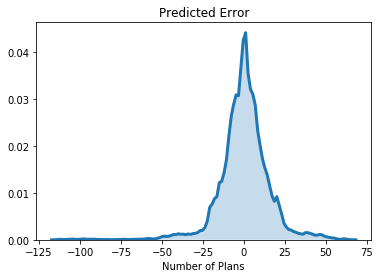

In [34]:
# distribution of errors - as they come
_ = sns.distplot(errors, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3})
_ = plt.title("Predicted Error")
_ = plt.xlabel("Number of Plans")

In [31]:
# Consider an error larger than 3 (3 plan options) to be a large error (20% of the mean)
lrg_error=abs(errors)>3
print(errors)
print(errors.shape)
print(lrg_error)
print(len(sum(lrg_error)))

[[  0.    22.01   2.32 ...  12.59  16.97  21.29]
 [-21.     1.01 -18.68 ...  -8.41  -4.03   0.29]
 [ -2.    20.01   0.32 ...  10.59  14.97  19.29]
 ...
 [-11.    11.01  -8.68 ...   1.59   5.97  10.29]
 [-14.     8.01 -11.68 ...  -1.41   2.97   7.29]
 [-23.    -0.99 -20.68 ... -10.41  -6.03  -1.71]]
(816, 816)
[[False  True False ...  True  True  True]
 [ True False  True ...  True  True False]
 [False  True False ...  True  True  True]
 ...
 [ True  True  True ... False  True  True]
 [ True  True  True ... False False  True]
 [ True False  True ...  True  True False]]
816


In [36]:
# Bagging Regressor
br_mod=BaggingRegressor(n_estimators = 10, random_state = 42)
br_mod.fit(X_train,Y_train.ravel())

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=42, verbose=0,
                 warm_start=False)

In [41]:
# Use the Model to Predict the Test set and Evaluate the fit

Y_test_predbr = br_mod.predict(X_test)

# Calculate the errors
errors_br = Y_test_predbr - Y_test
errors_br_perc = errors_br/Y_test
# Print the mean absolute error (MAE) in number of plans unit and percentage
print('Mean Absolute Error:', round(np.mean(abs(errors_br_perc)),2), "%")

Mean Absolute Error: 0.94 %


In [43]:
print(errors_br.shape)
print(X_train.shape)


(816, 816)
(1902, 47)
